In [1]:
import cv2

import numpy as np;
import tifffile
import os
import matplotlib.pyplot as plt
import copy
%load_ext autoreload
%autoreload 2

In [2]:
# From: https://stackoverflow.com/questions/8076889/how-to-use-opencv-simpleblobdetector

# Get images with segmentation

which_slice = 13
alpha = 0.15

f = lambda tif : (alpha*tif.asarray()[which_slice]).astype('uint8')

dat_foldername = r'..\point_cloud_alignment'

vol0 = os.path.join(dat_foldername, 'img100.tif')
with tifffile.TiffFile(vol0) as tif:
    im1_raw = f(tif)

vol1 = os.path.join(dat_foldername, 'img101.tif')
with tifffile.TiffFile(vol1) as tif:
    im2_raw = f(tif)

## Blob detector

In [3]:
from DLC_for_WBFM.utils.feature_detection.utils_detection import detect_blobs


In [4]:
keypoints, _ = detect_blobs(im1_raw)

# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
# the size of the circle corresponds to the size of blob
im1 = cv2.GaussianBlur(im1_raw,(3,3),0)

im_with_keypoints = cv2.drawKeypoints(im1, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Show blobs
#cv2.imshow("Keypoints", im_with_keypoints)

Text(0.5, 1.0, 'Found 38 keypoints')

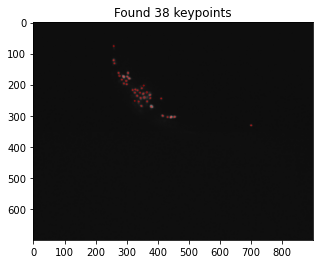

In [5]:
%matplotlib inline
plt.imshow(im_with_keypoints)
plt.title(f"Found {len(keypoints)} keypoints")

## 3d blob detection

In [6]:
from ipywidgets import interact
import open3d as o3d
from DLC_for_WBFM.utils.feature_detection.utils_features import build_feature_tree
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import visualize_cluster_labels
import pandas as pd

In [7]:
alpha = 0.15

f = lambda dat, which_slice : (alpha*dat[which_slice]).astype('uint8')

dat_foldername = r'..\point_cloud_alignment'

vol0 = os.path.join(dat_foldername, 'img100.tif')


num_slices = 33
with tifffile.TiffFile(vol0) as tif:
    dat = tif.asarray()

## Try to track via ICP on planes

In [8]:
from DLC_for_WBFM.utils.feature_detection.utils_detection import build_point_clouds_for_volume, build_correspondence_icp


In [9]:
# Build point clouds for each plane

all_keypoints_pcs = build_point_clouds_for_volume(dat,
                                                  num_slices,
                                                  alpha)

In [10]:
all_icp = build_correspondence_icp(all_keypoints_pcs)

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


## Build tracklets from the above matches

In [78]:
# From: http://www.open3d.org/docs/release/tutorial/pipelines/icp_registration.html
import copy
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import visualize_tracks_simple
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import build_tracklets_from_matches

In [98]:
clust_df = build_tracklets_from_matches(all_keypoints_pcs, all_icp)

In [105]:
np.array(clust_df['all_xyz'][0]).shape

(9, 3)

## Visualize the tracklets 1: by cluster

In [ ]:
# Build full point cloud

full_pc = o3d.geometry.PointCloud()
for pc in all_keypoints_pcs:
    full_pc = full_pc + pc
full_pc.paint_uniform_color([0.5,0.5,0.5])

In [87]:
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import visualize_clusters_from_dataframe

In [90]:
visualize_clusters_from_dataframe(full_pc, clust_df)

## Visualize the tracklets 2: using connecting lines

In [91]:
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *

In [92]:
all_matches = [np.array(icp.correspondence_set) for icp in all_icp]
all_pc = copy.copy(all_keypoints_pcs)

In [93]:
visualize_tracks_multiple_matches(all_pc, all_matches)

In [ ]:
line = build_line_set_from_matches(all_pc[0], all_pc[1], all_matches[0])

## Get centroid locations from dataframe

In [94]:
centroids = clust_df[]

,clust_ind,all_ind_local,all_ind_global,slice_ind,extended_this_slice,not_finished,colors
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 23]","[68, 69, 70, 71, 72, 74, 78, 82, 115]","[3, 4, 5, 6, 7, 8, 9, 10, 11]",False,False,"[0.12156862745098039, 0.4666666666666667, 0.70..."
1,1,"[1, 2, 2, 3, 1, 0, 0, 4, 27, 41, 49]","[73, 76, 80, 85, 93, 116, 150, 192, 259, 320, ...","[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",False,False,"[0.12156862745098039, 0.4666666666666667, 0.70..."
2,2,"[3, 3, 2, 2, 5, 28, 38]","[77, 81, 84, 94, 121, 178, 226]","[8, 9, 10, 11, 12, 13, 14]",False,False,"[0.12156862745098039, 0.4666666666666667, 0.70..."
3,3,"[1, 1, 1, 0, 2, 24, 39]","[75, 79, 83, 92, 118, 174, 227]","[8, 9, 10, 11, 12, 13, 14]",False,False,"[0.12156862745098039, 0.4666666666666667, 0.70..."
4,4,"[8, 9, 11, 8, 17, 36, 45]","[90, 101, 127, 158, 205, 268, 324]","[10, 11, 12, 13, 14, 15, 16]",False,False,"[0.12156862745098039, 0.4666666666666667, 0.70..."
...,...,...,...,...,...,...,...
166,166,"[41, 20, 8, 6]","[1021, 1055, 1083, 1117]","[29, 30, 31, 32]",True,True,"[0.6196078431372549, 0.8549019607843137, 0.898..."
167,167,"[6, 7, 10]","[1041, 1082, 1121]","[30, 31, 32]",True,True,"[0.6196078431372549, 0.8549019607843137, 0.898..."
168,168,"[22, 6, 5]","[1057, 1081, 1116]","[30, 31, 32]",True,True,"[0.6196078431372549, 0.8549019607843137, 0.898..."
169,169,"[14, 0]","[1089, 1111]","[31, 32]",True,True,"[0.6196078431372549, 0.8549019607843137, 0.898..."


# OLD

## Align the volume before blob identification

In [ ]:

from DLC_for_WBFM.utils.feature_detection.utils_features import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *

In [ ]:
def align_pair_of_images(im1, im2, use_skimage=True):
    """
    Aligns two images using orb-generated features
    
    Args:
        im1: numpy image in XY or XYC (color optional)
        
        im2: same format as im1
    """
    
    # Convert images to grayscale
    im1Gray, im2Gray = convert_to_grayscale(im1, im2)

    # Features
    keypoints1, keypoints2, matches = detect_features_and_match(im1, im1Gray, im2, im2Gray)

    # Extract location of good matches
    points1, points2 = extract_location_of_matches(matches, keypoints1, keypoints2)

    # Find homography
#     h, mask = cv2.estimateAffine2D(points1, points2)
    if use_skimage:
        h = transform.estimate_transform('euclidean', points1, points2)
    else:
        h, mask = cv2.estimateAffinePartial2D(points1, points2)

    # Use homography
    # Only width and height, removing color channels if any
    if use_skimage:
        im1Reg = transform.warp(im1, inverse_map=h.inverse) 
#         im1Reg = None
    else:
        im1Reg = cv2.warpAffine(im1, h, im2.shape[:2])

    return im1Reg, h, keypoints1, keypoints2, matches

# ===============================================================================
# OLD

### Alternate clustering tests

In [ ]:
# def remove_outliers_from_2_clouds(this_pc, next_pc):
#     combined_pc = this_pc + next_pc
#     if len(this_pc.points) > 0 and len(next_pc.points) > 0:   
#         cl, ind = combined_pc.remove_radius_outlier(nb_points=1, radius=3.0)

#         cut = len(this_pc.points)
#         print(ind)

#         out1 = this_pc.select_by_index(ind[:cut])
#         out2 = next_pc.select_by_index(ind[cut:])
#     else:
#         print("Empty point cloud; removing no outliers")
    
#     return out1, out2

In [ ]:
# Build correspondence between each pair of planes
# import copy

# all_icp = []
# opt = {'max_correspondence_distance':10.0}

# for i in range(10, num_slices-1):
# #     print(f"{i} / {num_slices}")
# #     this_pc = 
# #     next_pc = 
    
#     this_pc, next_pc = remove_outliers_from_2_clouds(copy.deepcopy(all_keypoints_pcs[i]), copy.deepcopy(all_keypoints_pcs[i+1]))
    
#     reg = o3d.pipelines.registration.registration_icp(this_pc, next_pc, **opt)
    
#     all_icp.append(reg)

In [ ]:
# # Try correspondence via global registration, not ICP

# all_icp = []
# feature_opt = {'search_param':o3d.geometry.KDTreeSearchParamHybrid(radius=50.0, max_nn=10)}

# for i in range(10, num_slices-1):
# #     print(f"{i} / {num_slices}")
#     this_pc = all_keypoints_pcs[i]
#     next_pc = all_keypoints_pcs[i+1]
    
#     # Generate features
#     f1 = o3d.pipelines.registration.compute_fpfh_feature(this_pc, **feature_opt)
#     f2 = o3d.pipelines.registration.compute_fpfh_feature(next_pc, **feature_opt)
    
#     reg =  o3d.pipelines.registration.registration_ransac_based_on_feature_matching(this_pc, next_pc, f1, f2)
    
#     all_icp.append(reg)

## Simplest: find peaks

In [ ]:
from skimage.feature import peak_local_max

In [ ]:
# Background subtraction:
# https://docs.opencv.org/3.3.0/db/d5c/tutorial_py_bg_subtraction.html
# Peak detection:
# https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html

#im1 = np.abs(cv2.GaussianBlur(im1_raw,(3,3),0) - np.min(im1_raw))
im1 = cv2.GaussianBlur(im1_raw,(3,3),0)
fgbg = cv2.createBackgroundSubtractorKNN()
fgbg.apply(im1)

%matplotlib notebook
plt.imshow(im1)

thresh = np.mean(im1)+10
coordinates = peak_local_max(im1, min_distance=5, num_peaks=200, threshold_abs=thresh)

In [ ]:

plt.imshow(im1, cmap=plt.cm.gray)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

## Thresholds

In [ ]:
# Do some preprocessing
# From: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
# Otsu's thresholding
im1 = cv2.GaussianBlur(im1_raw,(5,5),0)
#ret2,im1 = cv2.threshold(im1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
im1 = cv2.adaptiveThreshold(im1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

# Make neurons dark spts
#im1 = cv2.bitwise_not(im1)

In [ ]:
%matplotlib inline
plt.imshow(im1)

## Contours

In [ ]:
# Just find contours
%matplotlib inline
contours, hierarchy = cv2.findContours(im1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

im = np.expand_dims(im1, axis=2).repeat(3, axis=2) 
for k, _ in enumerate(contours):
    im = cv2.drawContours(im, contours, k, (0, 230, 255), 6)
plt.imshow(im)

## Try to track via clustering

In [ ]:

all_keypoints = []
all_ims_with_kps = []
    
for i in range(num_slices):
#     print(f"{i} / {num_slices}")
    im1_raw = f(dat, i)
    kp, im1 = detect_blobs(im1_raw)
    # Add to make the format: ZXY
    kp_3d = np.array([np.hstack((i, row.pt)) for row in kp])
    all_keypoints.extend(kp_3d)
    
    im_with_keypoints = cv2.drawKeypoints(im1, kp, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    all_ims_with_kps.append(im_with_keypoints)

all_keypoints = np.array(all_keypoints)

In [ ]:
def my_plot(i): 
    plt.imshow(all_ims_with_kps[i])
    plt.title(f"{i}")

In [ ]:
interact(my_plot, i=(0,num_slices-1))

In [ ]:

def combine_2d_blobs(all_keypoints, min_z_detections=3):
    """
    Assumes that a real neuron will be detected on more than one plane, and combines them
    """
    
#     all_xyz = all_keypoints[:].pt
    n, point_cloud, tree = build_feature_tree(all_keypoints)
    
    return point_cloud

In [ ]:
pc = combine_2d_blobs(all_keypoints)

In [ ]:
#o3d.visualization.draw_geometries([pc])

In [ ]:
# from sklearn.cluster import SpectralClustering
# opt = {'n_neighbors':2,
#        'n_clusters':150}
# clusterer = SpectralClustering(**opt)

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# opt = {'distance_threshold':2.0,
#        'compute_full_tree':True,
#        'linkage':'single',
#        'n_clusters':None}
# clusterer = AgglomerativeClustering(**opt)

In [ ]:
from sklearn.cluster import OPTICS
opt = {'min_samples':2,
       'max_eps':3.0}
clusterer = OPTICS(**opt)

In [ ]:
labels = clusterer.fit_predict(pc.points)

In [ ]:
visualize_cluster_labels(labels, pc)

## Simple test: dbscan

In [ ]:
labels = np.array(pc.cluster_dbscan(eps=1.5, min_points=3))

In [ ]:
visualize_cluster_labels(labels, pc)